# Stable Baselines3 Tutorial - Multiprocessing of environments
- How to use vectorized environments (multiprocessing).
- How to estimate the tradeoff between training speed and sample efficiency.
- Compare performance of DummyVecEnv vs SubprocVecEnv.

## 1. About vectorized environments

### Intro
A method to stack multiple independent environments into one. Benefits:
* Experience is collected more quickly.
* More diverse experience (range of states), improving exploration.

Types of vectorized environment:
* SubprocVecEnv, running each environment in a separate process.
* DummyVecEnv, running all environments sequentially on the same process.

Tip: DummyVecEnv is faster in simple envs. due to communication delays in subprocesses.

### Dependencies and libraries

In [1]:
# Dependencies: install swig

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO, A2C

# Evaluate function to use:
from stable_baselines3.common.evaluation import evaluate_policy

### Define an environment function
The multiprocessing implementation requires a function to be called inside the process to instantiate a gym env.

In [2]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID.
    :param rank: (int) index of the subprocess.
    :param seed: (int) the initial seed for RNG.
    """
    def _init():
        env = gym.make(env_id)
        # Important: use a different seed for each environment.
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

Stable-Baselines directly provides a helper function to create a vectorized environment:

In [3]:
from stable_baselines3.common.env_util import make_vec_env

## 2. Testing training speed vs sample efficienty

### Define constants and environment to use

In [4]:
# Environment to use:
env_id = 'CartPole-v1'

# The different number of processes that will be used:
PROCESSES_TO_TEST = [1, 2, 4, 8, 16] 
NUM_EXPERIMENTS = 5 # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = A2C

# We will create one environment to evaluate the agent on.
from stable_baselines3.common.monitor import Monitor
eval_env = Monitor(gym.make(env_id)) # AH: Wrapped with Monitor to prevent erroneous metrics.

### Training a model with different numbers of processes

In [5]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    if n_procs == 1:
        # No need for multiprocessing.
        train_env = DummyVecEnv(
            [lambda: gym.make(env_id)]
        )
    else:
        # Use 'fork' method for launchint the processes (see doc.).
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = SubprocVecEnv(
            [make_env(env_id, i+total_procs) for i in range(n_procs)],
            start_method='fork'
        )
    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # It's recommended to run several experiments due to variability in results.
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        time_used = time.time() - start
        times.append(time_used)
        # Evaluate the trained model on the evaluation env.
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
        
    # Important: Close the subprocesses to prevent memory issues!
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


### Results

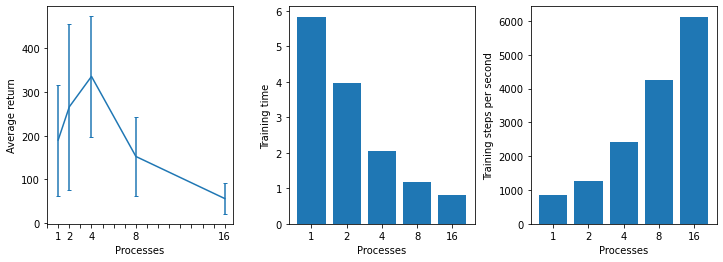

In [6]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

figure = plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2)
plt.xlabel('Processes')
plt.xticks(np.arange(17), ['', '1', '2', '', '4', '', '', '', '8', '', '', '', '', '', '', '', '16'])
plt.ylabel('Average return')

plt.subplot(1, 3, 2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_times)
plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
plt.xlabel('Processes')
_ = plt.ylabel('Training time')

plt.subplot(1, 3, 3)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
plt.xlabel('Processes')
_ = plt.ylabel('Training steps per second')

There is a trade-off between sample efficiency, diverse experience and wall clock time:
- Using more processes requires less total training time (< 1 sec with 16 processes).
- However the highest performance (avg. reward) was obtained with only 4 processes.
- Top steps / sec (≈6,000) is reached with 16 processes.

### Getting the best performance in a fixed amount of time
(E.g. 15 seconds per experiment.)

In [7]:
SECONDS_PER_EXPERIMENT = 15
# Estimate how many steps each experiment should run based on previous metric.
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]

reward_averages = []
reward_std = []
training_times = []
total_procs = 0

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs} for steps = {train_steps}')
    if n_procs == 1:
        # No need for multiprocessing.
        train_env = DummyVecEnv(
            [lambda: gym.make(env_id)]
        )
    else:
        # Use 'fork' method for launchint the processes (see doc.).
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = SubprocVecEnv(
            [make_env(env_id, i+total_procs) for i in range(n_procs)],
            start_method='spawn' # NOTE the different argument here.
            # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
            # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])
        )
    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # It's recommended to run several experiments due to variability in results.
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps) # NOTE: not the constant, but the iterator.
        time_used = time.time() - start
        times.append(time_used)
        # Evaluate the trained model on the evaluation env.
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
        
    # Important: Close the subprocesses to prevent memory issues!
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1 for steps = 12844
Running for n_procs = 2 for steps = 18846
Running for n_procs = 4 for steps = 36354
Running for n_procs = 8 for steps = 63706
Running for n_procs = 16 for steps = 91862


### Results

Text(0, 0.5, 'Training steps per second')

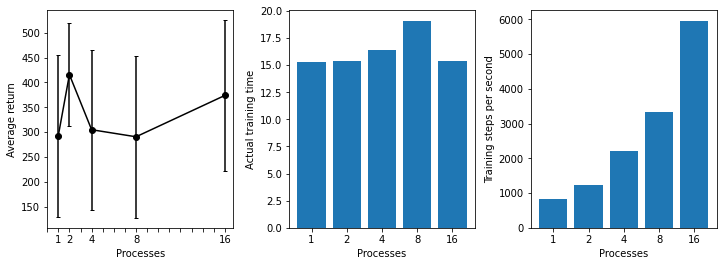

In [8]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2, c='k', marker='o')
plt.xlabel('Processes')
plt.xticks(np.arange(17), ['', '1', '2', '', '4', '', '', '', '8', '', '', '', '', '', '', '', '16'])
plt.ylabel('Average return')

plt.subplot(1,3,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_times)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Actual training time')

plt.subplot(1,3,3)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

Results show that:
- 2 processes reach maximum performance (avg. reward) in the same time.
- 16 processes may get better performance than 1, 4 and 8 processes (AH: why?).

Note: previous tests obtained higher avg. return with 4 processes.

## 3. DummyVecEnv vs SubprocVecEnv

In [9]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    # Here we are using only one process even for n_env > 1
    # Equivalent to train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs) # By default it uses DummyVecEnv.
    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # It's recommended to run several experiments due to variability in results.
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        time_used = time.time() - start
        times.append(time_used)
        # Evaluate the trained model on the evaluation env.
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
        
    # Important: Close the subprocesses to prevent memory issues!
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


### Results

Text(0, 0.5, 'Training steps per second')

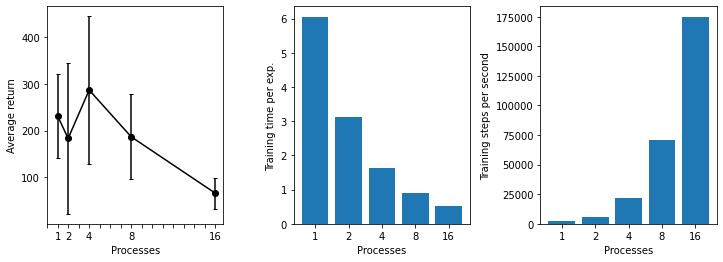

In [12]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2, c='k', marker='o')
plt.xlabel('Processes')
plt.xticks(np.arange(17), ['', '1', '2', '', '4', '', '', '', '8', '', '', '', '', '', '', '', '16'])
plt.ylabel('Average return')

plt.subplot(1,3,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_times)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training time per exp.')

plt.subplot(1,3,3)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

Results show that:
- SubprocVecEnv reached top ≈6,000 steps/sec (with 16 processes).
- But DummyVecEnv reached 175,000 steps/sec with the same 16 (fake) processes!
- The reason is that in simple environments the bottleneck comes from from the synchronization and communication between processes.